In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import svm
from sklearn.svm import SVC, LinearSVC , LinearSVR
from keras.layers import Dense , LSTM
from keras.models import Sequential
import tensorflow as tf
pd.set_option('max_columns', 30)
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline 

Using TensorFlow backend.


# Importing Dataset FD004

In [2]:
def load_train_data(train_FD004):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\train_FD004'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data 

In [4]:
def load_test_data(FD004):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\test_FD004'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    
    RUL = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\RUL_FD004' + '.txt', sep = ' ', header = None)
    RUL = RUL[list(range(0, 1))]
    RUL['unit'] = list(range(1, len(RUL) + 1))
    RUL.rename(columns = {0 : 'RUL'}, inplace = True)
    
    data = data.merge(RUL, how = 'left', left_on = 'unit', right_on = 'unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis = 1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data

In [5]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    return (arr - mean) / std

In [6]:
def compute_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return np.sum(np.exp(d[d >= 0] / 10) - 1) + np.sum(np.exp(-1 * d[d < 0] / 13) - 1)

def MSE(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    return np.sqrt(np.sum(d ** 2)) / len(d)

def MAE(RUL_real, RUL_pred):
    return np.mean(np.abs(RUL_pred - RUL_real))

In [7]:
train_fd1 = load_train_data('FD004')
test_fd1 = load_test_data('FD004')

# Data Visualisation

In [8]:
train_fd1.describe()

,unit,cycle,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,total_cycles,RUL
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,124.325181,134.311417,23.999823,0.571347,94.031576,472.882435,579.420056,1417.896600,1201.915359,8.031626,11.589457,283.328633,2228.686034,8524.673301,1.096445,42.874529,266.735665,2334.427590,8067.811812,9.285604,0.023252,347.760029,2228.613283,97.751396,20.864333,12.518995,267.622835,133.311417
std,71.995350,89.783389,14.780722,0.310703,14.251954,26.436832,37.342647,106.167598,119.327591,3.622872,5.444017,146.880210,145.348243,336.927547,0.127681,3.243492,138.479109,128.197859,85.670543,0.750374,0.004685,27.808283,145.472491,5.369424,9.936396,5.962697,79.231517,89.783389
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1024.420000,3.910000,5.670000,136.170000,1914.720000,7984.510000,0.930000,36.040000,128.310000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300,128.000000,0.000000
25%,60.000000,62.000000,10.004600,0.250700,100.000000,445.000000,549.330000,1350.550000,1119.490000,3.910000,5.720000,142.920000,2211.950000,8320.590000,1.020000,41.760000,134.520000,2387.910000,8062.630000,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100,202.000000,61.000000
50%,126.000000,123.000000,25.001400,0.700000,100.000000,462.540000,555.740000,1367.680000,1136.920000,7.050000,9.030000,194.960000,2223.070000,8362.760000,1.030000,42.330000,183.450000,2388.060000,8083.810000,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100,259.000000,122.000000
75%,185.000000,191.000000,41.998100,0.840000,100.000000,491.190000,607.070000,1497.420000,1302.620000,10.520000,15.480000,394.280000,2323.930000,8777.250000,1.260000,45.220000,371.400000,2388.170000,8128.350000,9.365800,0.030000,368.000000,2324.000000,100.000000,28.560000,17.135500,313.000000,190.000000
max,249.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,21.610000,570.810000,2388.640000,9196.810000,1.320000,48.360000,537.490000,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200,543.000000,542.000000


In [9]:
train_fd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61249 entries, 0 to 61248
Data columns (total 28 columns):
unit            61249 non-null int64
cycle           61249 non-null int64
2               61249 non-null float64
3               61249 non-null float64
4               61249 non-null float64
5               61249 non-null float64
6               61249 non-null float64
7               61249 non-null float64
8               61249 non-null float64
9               61249 non-null float64
10              61249 non-null float64
11              61249 non-null float64
12              61249 non-null float64
13              61249 non-null float64
14              61249 non-null float64
15              61249 non-null float64
16              61249 non-null float64
17              61249 non-null float64
18              61249 non-null float64
19              61249 non-null float64
20              61249 non-null float64
21              61249 non-null int64
22              61249 non-null int64
23

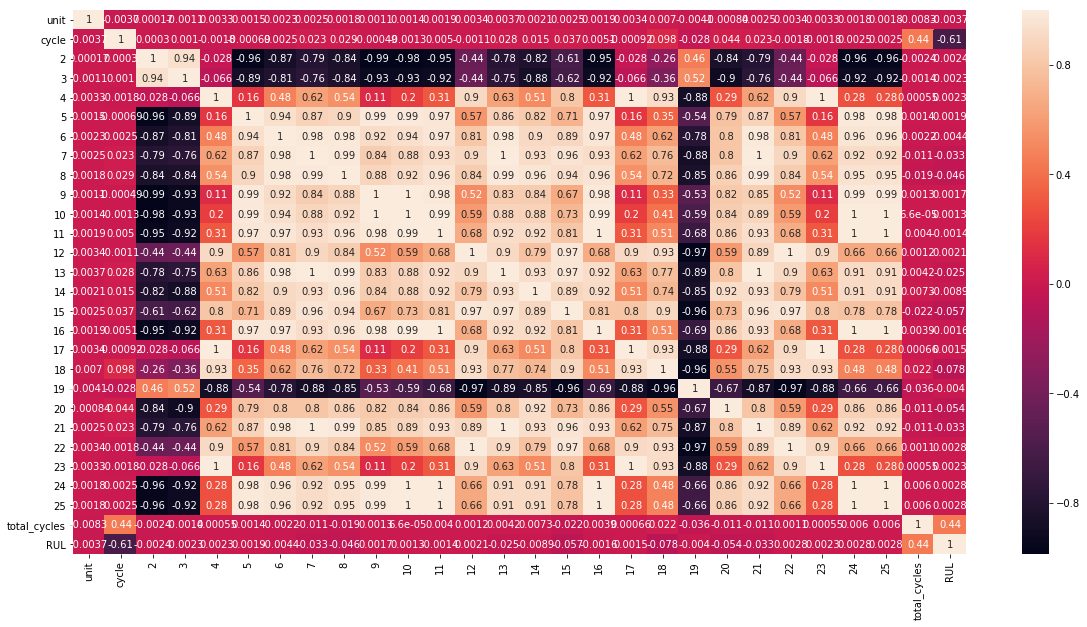

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(train_fd1.corr() , annot = True)

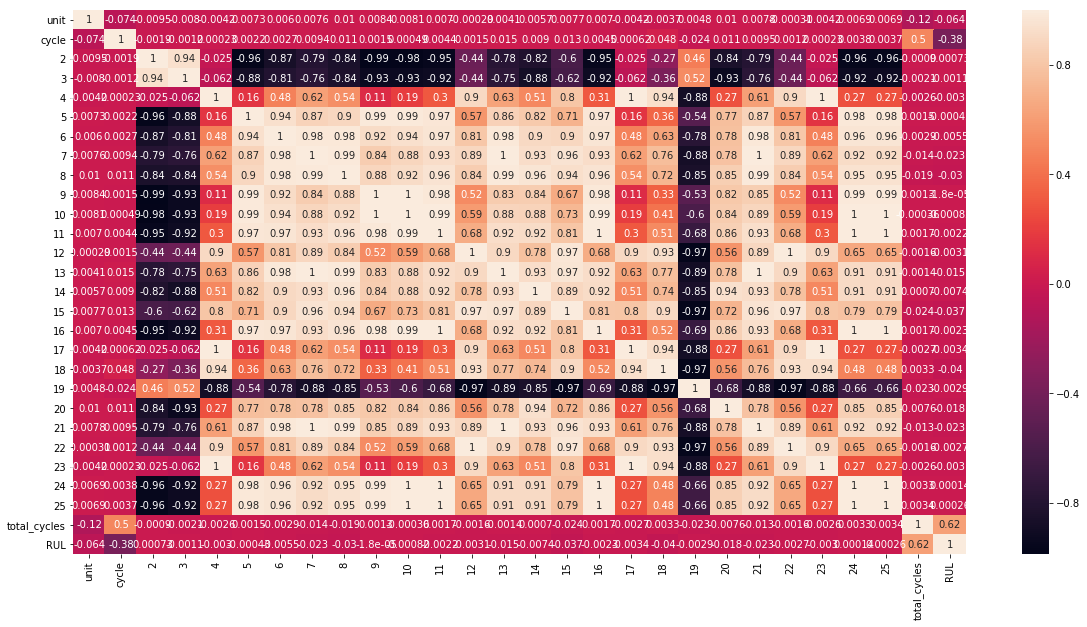

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(test_fd1.corr() , annot = True)

In [12]:
features = list(range(2, 26))

train_fd1[features] = train_fd1[features].apply(normalize, axis = 0)
test_fd1[features] = test_fd1[features].apply(normalize, axis = 0)

test_rows = test_fd1.groupby(['unit']).agg({'cycle' : max})
test_rows = test_rows.reset_index()
test_rows = test_rows.merge(test_fd1, how = 'left', left_on = ['unit', 'cycle'],
                                                    right_on = ['unit', 'cycle'])

In [13]:
y = train_fd1['RUL'].values

X_pred = test_rows[features].dropna(how = 'all', axis = 1)

X = train_fd1[features].dropna(how = 'all', axis = 1)

X = X.as_matrix()
X_pred = X_pred.as_matrix()

y_real = test_rows['RUL'].values

In [14]:
print(y.shape)
print(X.shape)
print(X_pred.shape)
print(y_real.shape)

(61249,)
(61249, 24)
(248, 24)
(248,)


# Neural Network Regressor

In [15]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [24])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [15, 30, 15])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X},
                                                    y = np.array(y, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X_pred)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\dell\\AppData\\Local\\Temp\\tmp4kudoz1w', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023FC967D390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for upd

In [16]:
print(y_pred)

<generator object Estimator.predict at 0x0000023FC964EFC0>


In [17]:
y_pred = [val for val in y_pred]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\dell\AppData\Local\Temp\tmp4kudoz1w\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [18]:
print(y_pred)

[164.6992   154.8517   153.49654  170.94774  167.91759  135.18788
 149.74995  117.01437  144.49031  151.6063   153.68527  131.93448
 143.54756  154.0471   152.4351   170.74266  133.30995  169.73886
 140.12059  144.39674  169.76976  102.14253  103.35096  152.83676
 164.61963  103.52859  150.56134  139.01689  172.17451  171.9732
 101.94303  168.19731  149.92946  104.88592  139.92125  143.24692
 147.67924  140.7761   166.40347  105.31662  144.86299  102.708954
 103.151634 142.73099  102.85361  143.59952  121.04722  145.02179
 140.5869   145.02979  162.27629  176.64252  144.16861  152.95073
 170.41896  153.74261  103.15115  149.26036  139.5849   144.36331
 120.63342  164.2983   149.0856   166.5429   101.310814 102.54395
 135.90869  148.75012   95.8157   123.69929  160.32086  150.28839
 122.82627  146.04166  150.97542  157.44011  156.0208   144.68317
 170.66536  131.98175  148.52887  165.09518  155.54205  145.40742
 105.17968  141.40112  154.07314  134.89749  166.39577  149.07701
 121.18745

In [19]:
print(len(X))
print(len(y))
print(len(y_pred))
print(len(y_real))

61249
61249
248
248


In [20]:
print(y_real)

[ 22  39 107  75 149  78  94  14  99 162 143   7  71 105  12 160 162 104
 194  82  91  11  26 142  39  92  76 124  64 118   6  22 147 126  36  73
  89  11 151  10  97  30  42  60  85 134  34  45  24  86 119 151 142 176
 157  67  97   8 154 139  51  33 184  46  12 133  46  46  12  33  15 176
  23  89 124 163  25  74  78 114  96  10 172 166 115  70  94  56  86  96
  50  73 154 129 171  71 105 113  37   7  13  22   9 120 100 107  41 153
 126  59  18  66  13  14 139  13  75   8 109 137  41 192  23  86 184  15
 195 126 120 165 101 116 126  36   7 122 159  88 173 146 130 108  53 162
  59 100  56 145  76  57  31  88 173  34   7 133 172   6  22  83  82  84
  95 174 111  72 109  87 179 158 126  12   8  10 123 103  12 106  12  32
  37 116  15  10  46 142  24 135  56  43 178  71 104  15 166  89  36  11
  92  96  59  13 167 151 154 109 116  91  11  88 108  76  14  89 145  17
  66 154  41 182  73  39  58  14 145  88 162 189 120  98  33 184 110  68
  24  75  18  16 166  98 176  81 118  35 131 194 11

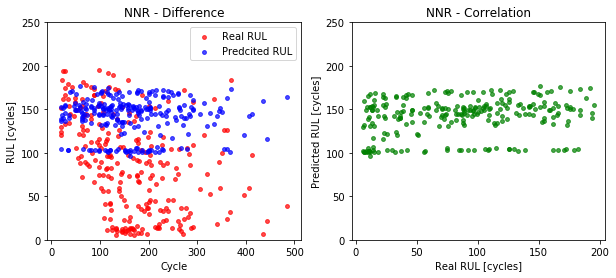

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('NNR - Difference')

axes[1].scatter(y_real, y_pred, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('NNR - Correlation')

axes[0].legend()

plt.show()

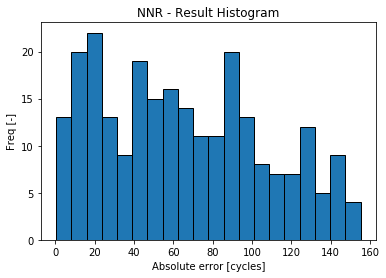

In [22]:
plt.hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('NNR - Result Histogram')
plt.show()

In [23]:
print('Average score per UUT:', compute_score(y_real, y_pred) / 100)
print('Mean squared Error:', MSE(y_real, y_pred))
print('Median difference:', np.median(np.abs(y_real - y_pred)))

Average score per UUT: 453913.19653611124
Mean squared Error: 4.906783103615365
Median difference: 60.77975082397461


# Support Vector Machine Regression

In [24]:
model = svm.SVR()
model.fit(X, y)
y_pred_svm = model.predict(X_pred)

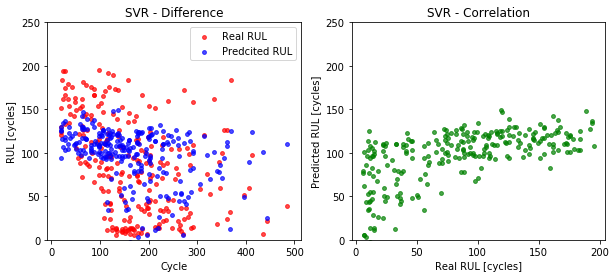

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred_svm, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('SVR - Difference')

axes[1].scatter(y_real, y_pred_svm, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('SVR - Correlation')

axes[0].legend()

plt.show()

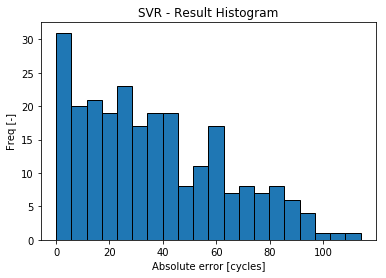

In [26]:
plt.hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('SVR - Result Histogram')
plt.show()

In [27]:
print('Average score per UUT:', compute_score(y_real, y_pred_svm) / 100)
print('Mean squared Error:', MSE(y_real, y_pred_svm))
print('Median difference:', np.median(np.abs(y_real - y_pred_svm)))

Average score per UUT: 2739.2592214722313
Mean squared Error: 2.847026580836087
Median difference: 31.984724123610942


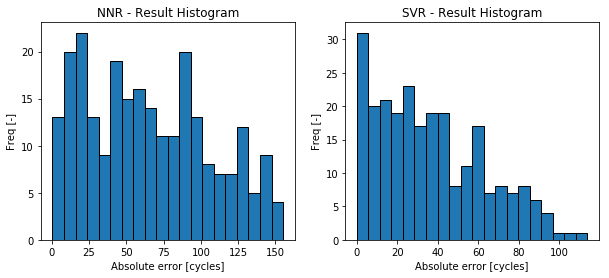

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axes[0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0].set_xlabel('Absolute error [cycles]')
axes[0].set_ylabel('Freq [-]')
axes[0].set_title('NNR - Result Histogram')

axes[1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[1].set_xlabel('Absolute error [cycles]')
axes[1].set_ylabel('Freq [-]')
axes[1].set_title('SVR - Result Histogram')
plt.show()

# Decision Tree Regressor

In [29]:
regr_1 = DecisionTreeRegressor(max_depth= 4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth= 4),
                          n_estimators=300, random_state = None)

regr_1.fit(X, y)
regr_2.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=None)

In [30]:
y_1 = regr_1.predict(X_pred)
y_2 = regr_2.predict(X_pred)

In [31]:
print(len(X))
print(len(y))
print(len(y_1))
print(len(y_2))
len(X) == len(y)

61249
61249
248
248


True

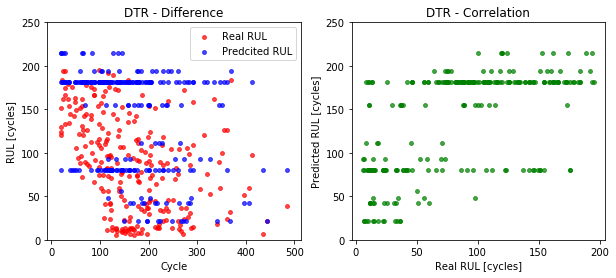

In [32]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_1, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTR - Difference')

axes[1].scatter(y_real, y_1, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTR - Correlation')

axes[0].legend()

plt.show()

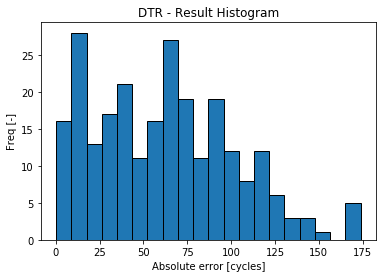

In [33]:
plt.hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTR - Result Histogram')
plt.show()

In [34]:
print('Average score per UUT:', compute_score(y_real, y_1) / 100)
print('Mean squared Error:', MSE(y_real, y_1))
print('Median difference:', np.median(np.abs(y_real - y_1)))

Average score per UUT: 1499458.331670419
Mean squared Error: 4.692845928864786
Median difference: 61.9658782040957


# Decision Tree Regressor using Adaboost

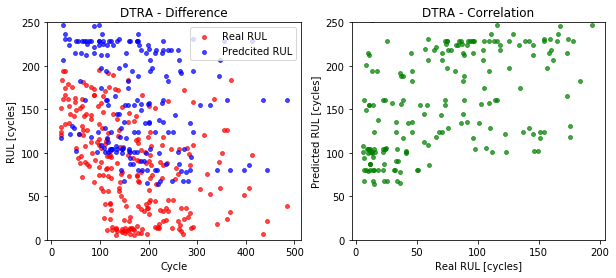

In [35]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_2, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTRA - Difference')

axes[1].scatter(y_real, y_2, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTRA - Correlation')

axes[0].legend()

plt.show()

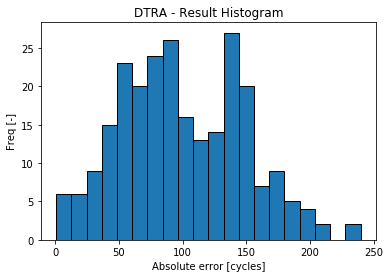

In [36]:
plt.hist(np.abs(y_real - y_2), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTRA - Result Histogram')
plt.show()

In [37]:
print('Average score per UUT:', compute_score(y_real, y_2) / 100)
print('Mean squared Error:', MSE(y_real, y_2))
print('Median difference:', np.median(np.abs(y_real - y_2)))

Average score per UUT: 483067507.7953878
Mean squared Error: 7.077543486844348
Median difference: 94.2844282708459


# KNN Regressor

In [38]:
neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')

In [39]:
KNeighborsRegressor()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [40]:
y_3 = neigh.predict(X_pred)

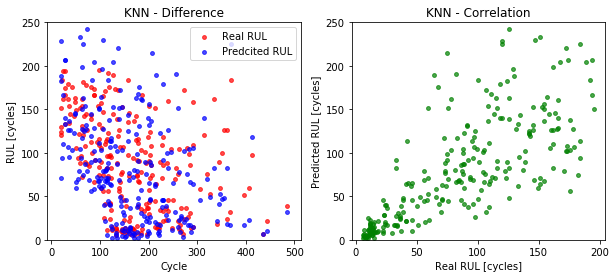

In [41]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_3, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('KNN - Difference')

axes[1].scatter(y_real, y_3, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('KNN - Correlation')

axes[0].legend()

plt.show()

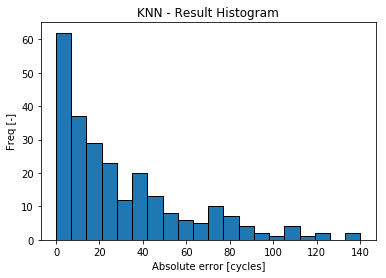

In [42]:
plt.hist(np.abs(y_real - y_3), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('KNN - Result Histogram')
plt.show()

In [43]:
print('Average score per UUT:', compute_score(y_real, y_3) / 100)
print('Mean squared Error:', MSE(y_real, y_3))
print('Median difference:', np.median(np.abs(y_real - y_3)))

Average score per UUT: 28064.46751426842
Mean squared Error: 2.7014656352028137
Median difference: 19.642857142857142


# Random Forest Regressor

In [44]:
regr1 = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
regr1.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [45]:
y_4 = regr1.predict(X_pred)

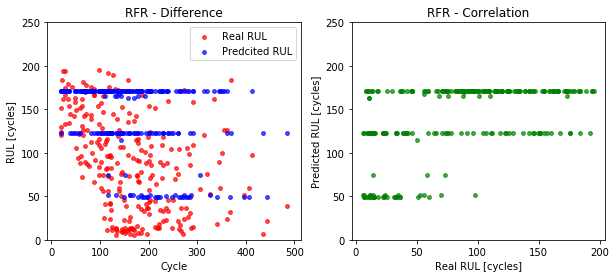

In [46]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_4, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('RFR - Difference')

axes[1].scatter(y_real, y_4, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('RFR - Correlation')

axes[0].legend()

plt.show()

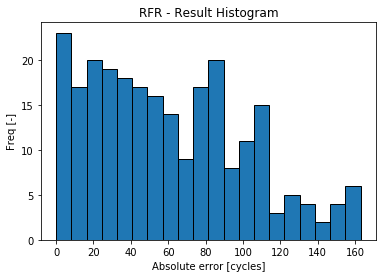

In [47]:
plt.hist(np.abs(y_real - y_4), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('RFR - Result Histogram')
plt.show()

In [48]:
print('Average score per UUT:', compute_score(y_real, y_4) / 100)
print('Mean squared Error:', MSE(y_real, y_4))
print('Median difference:', np.median(np.abs(y_real - y_4)))

Average score per UUT: 836768.5144142376
Mean squared Error: 4.6413224657402745
Median difference: 54.90824462918772


# Conclusions

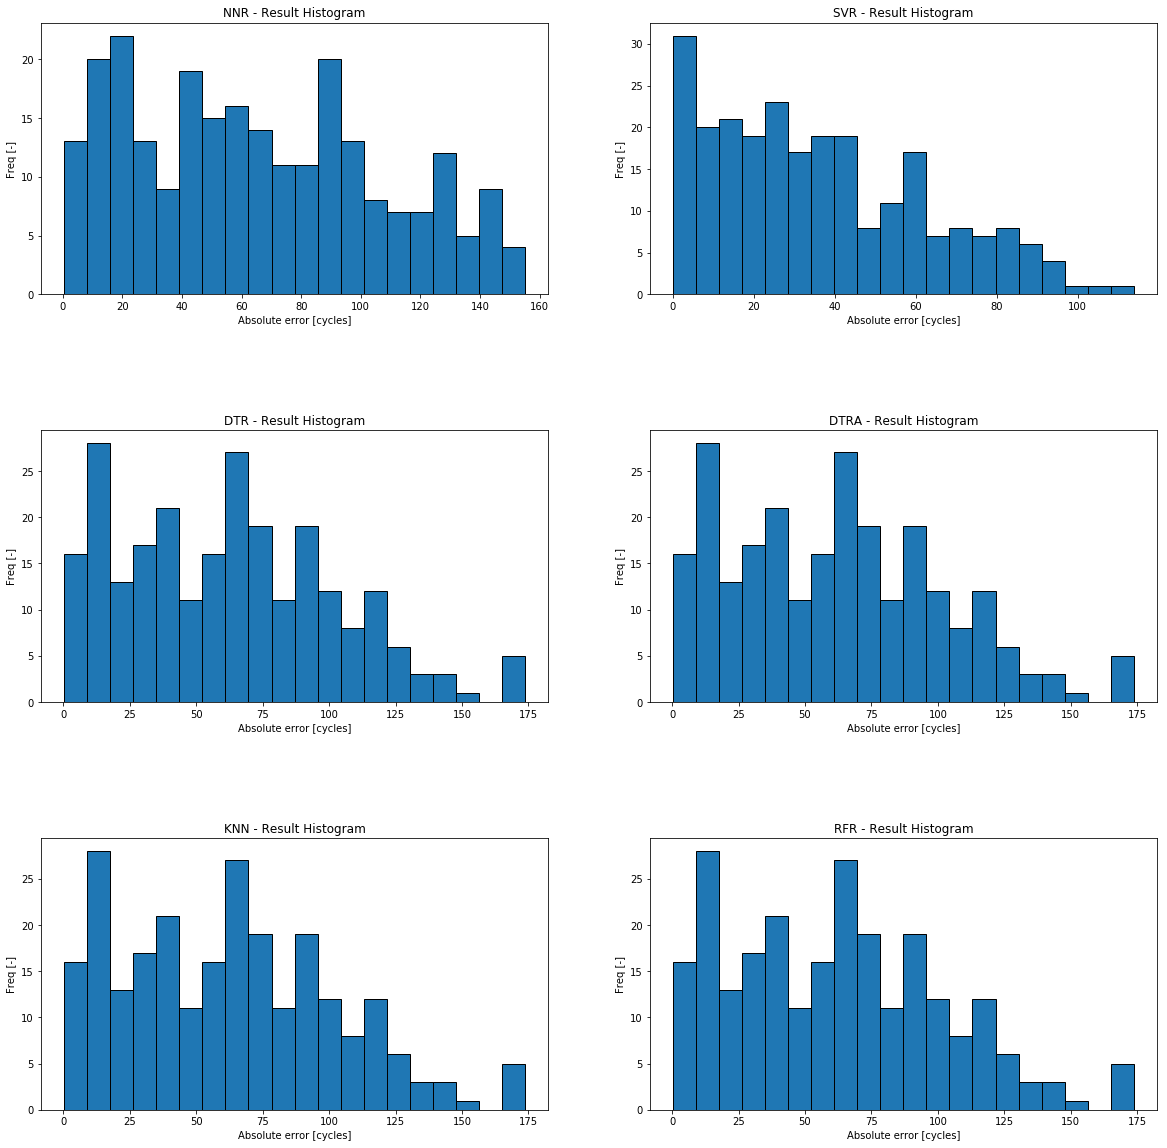

In [49]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axes[0,0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0,0].set_xlabel('Absolute error [cycles]')
axes[0,0].set_ylabel('Freq [-]')
axes[0,0].set_title('NNR - Result Histogram')

axes[0,1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[0,1].set_xlabel('Absolute error [cycles]')
axes[0,1].set_ylabel('Freq [-]')
axes[0,1].set_title('SVR - Result Histogram')

axes[1,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,0].set_xlabel('Absolute error [cycles]')
axes[1,0].set_ylabel('Freq [-]')
axes[1,0].set_title('DTR - Result Histogram')

axes[1,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,1].set_xlabel('Absolute error [cycles]')
axes[1,1].set_ylabel('Freq [-]')
axes[1,1].set_title('DTRA - Result Histogram')

axes[2,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,0].set_xlabel('Absolute error [cycles]')
axes[2,0].set_ylabel('Freq [-]')
axes[2,0].set_title('KNN - Result Histogram')

axes[2,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,1].set_xlabel('Absolute error [cycles]')
axes[2,1].set_ylabel('Freq [-]')
axes[2,1].set_title('RFR - Result Histogram')

plt.show()